In [198]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import io
from ase.optimize import BFGS, LBFGS, FIRE, LBFGSLineSearch
from ase.visualize import view
from ase.io import Trajectory
from ase import Atoms
from ase.build import bulk
import numpy as np
import matplotlib.pyplot as plt
from ase.build import add_vacuum

plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 12,              
    "axes.labelsize": 14,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 12,        
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,      
    "text.usetex": True       
})


macemp0 = mace_mp(dispersion=True, default_dtype="float64", model="medium")
macemp = mace_mp(dispersion=True, default_dtype="float64")


Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/macempa0mediummodel
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [243]:
macemp_omat = mace_mp(model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/mace-omat-0-medium.model", dispersion=True, default_dtype="float64")
macemp_omat_noD = mace_mp(model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/mace-omat-0-medium.model", dispersion=False, default_dtype="float64")

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [3]:
import importlib
import interlayer_spacing
importlib.reload(interlayer_spacing)

from interlayer_spacing import calculate_interlayer_spacing, set_interlayer_spacing

### Setup: create and geom-opt (mp0 + omat) MXene, G, GO, GOH

In [15]:
mxene_relaxed = io.read("structures/relaxed_mxene.xyz")
graphene_atoms = io.read("structures/graphene_atoms.xyz")

In [20]:
a = 3.03  

positions = [
    (0.0, 0.0, 0.5),  # C (middle layer)
    (1/3, 2/3, 0.35),  # Ti (bottom layer)
    (2/3, 1/3, 0.65),  # Ti (top layer)
    (1/3, 2/3, 0.80),  # O (top termination)
    (2/3, 1/3, 0.20),  # O (bottom termination)
]

symbols = ["C", "Ti", "Ti", "O", "O"]

cell = [
    [a, 0, 0],
    [-a/2, np.sqrt(3)/2 * a, 0],
    [0, 0, 20]
]

mxene_unit = Atoms(symbols=symbols, scaled_positions=positions, cell=cell, pbc=[True, True, False])

for atom in mxene_unit:
    if atom.symbol == 'O':
        if atom.position[2] < 0.5 * cell[2][2]:  # bottom O layer, fraction x cell parameter
            atom.tag = 1
        else:  # top O layer
            atom.tag = 3
    elif atom.symbol == 'C':
        atom.tag = 2
        

mxene_supercell = mxene_unit.repeat((4, 4, 1))
        
add_vacuum(mxene_supercell, 20.0)

In [21]:
mxene_relax_mp0 = mxene_supercell.copy()
mxene_relax_mp0.calc = macemp0
optimiser = BFGS(mxene_relax_mp0)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 14:29:09     -363.045908        1.157840
BFGS:    1 14:29:10     -363.694529        1.171301
BFGS:    2 14:29:11     -372.045322        1.359632
BFGS:    3 14:29:12     -381.539479        1.610541
BFGS:    4 14:29:13     -392.658177        1.983402
BFGS:    5 14:29:15     -406.550736        2.612705
BFGS:    6 14:29:16     -425.749539        3.647223
BFGS:    7 14:29:17     -456.084137        5.381531
BFGS:    8 14:29:18     -504.945867        6.516630
BFGS:    9 14:29:19     -558.855930        5.337270
BFGS:   10 14:29:20     -593.611944        2.763385
BFGS:   11 14:29:21     -605.978313        0.752172
BFGS:   12 14:29:22     -606.981325        0.474698
BFGS:   13 14:29:24     -607.502719        0.731859
BFGS:   14 14:29:25     -608.169773        0.930034
BFGS:   15 14:29:26     -610.781480        1.450060
BFGS:   16 14:29:27     -614.053925        1.902691
BFGS:   17 14:29:29     -617.497247        2.410251
BFGS:   18 14:

True

In [5]:
go = graphene_atoms.copy()
goh = graphene_atoms.copy()


# Add epoxy groups for GO (C/O = 50)
oxygen_positions = []
carbon_positions = go.get_positions()
num_carbons = len(carbon_positions)
num_oxygens = num_carbons // 50  # C/O ratio of 50

for i in range(num_oxygens):
    carbon_idx = np.random.randint(0, num_carbons)
    pos = carbon_positions[carbon_idx] - np.array([0, 0, 1.2])  # below carbon plane (in between carbon and mxene)
    oxygen_positions.append(pos)

go.extend(Atoms('O' * num_oxygens, positions=oxygen_positions))

# Add -OH groups for GOH
oxygen_positions = []
hydrogen_positions = []
for i in range(num_oxygens):
    carbon_idx = np.random.randint(0, num_carbons)
    pos_o = carbon_positions[carbon_idx] - np.array([0, 0, 1.53])
    pos_h = pos_o - np.array([0, 0, 0.98])
    oxygen_positions.append(pos_o)
    hydrogen_positions.append(pos_h)

goh.extend(Atoms('O' * num_oxygens, positions=oxygen_positions))
goh.extend(Atoms('H' * num_oxygens, positions=hydrogen_positions))

for atom in go:
    if atom.symbol == 'O':
        atom.tag = 11
for atom in goh:
    if atom.symbol == 'O':
        atom.tag = 11
    elif atom.symbol == 'H':
        atom.tag = 12

In [6]:
go_mace_relax = go.copy()
go_mace_relax.calc = macemp
optimiser = BFGS(go_mace_relax)
optimiser.run(fmax=0.001, steps=5000)

/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/torch_dftd/torch_dftd3_calculator.py:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  cell: Optional[Tensor] = torch.tensor(


      Step     Time          Energy          fmax
BFGS:    0 20:36:54     -466.334633       16.454457
BFGS:    1 20:36:55     -467.927597        4.451209
BFGS:    2 20:36:55     -468.205533        3.478318
BFGS:    3 20:36:56     -468.566415        2.968103
BFGS:    4 20:36:57     -468.663538        1.722527
BFGS:    5 20:36:57     -468.796102        0.628646
BFGS:    6 20:36:58     -468.833940        0.530242
BFGS:    7 20:36:59     -468.874182        0.646424
BFGS:    8 20:37:00     -468.904315        0.629228
BFGS:    9 20:37:00     -468.926669        0.335797
BFGS:   10 20:37:01     -468.938448        0.172961
BFGS:   11 20:37:01     -468.945834        0.353407
BFGS:   12 20:37:02     -468.954522        0.363407
BFGS:   13 20:37:03     -468.960837        0.186859
BFGS:   14 20:37:04     -468.964531        0.107849
BFGS:   15 20:37:05     -468.967109        0.123572
BFGS:   16 20:37:05     -468.969718        0.144892
BFGS:   17 20:37:06     -468.972667        0.105868
BFGS:   18 20:

True

In [7]:
io.write("go_mace_relax.xyz", go_mace_relax)

In [8]:
go_omat_relax = go.copy()
go_omat_relax.calc = macemp
optimiser = BFGS(go_omat_relax)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 20:37:31     -466.334633       16.454457
BFGS:    1 20:37:32     -467.927597        4.451209
BFGS:    2 20:37:33     -468.205533        3.478318
BFGS:    3 20:37:33     -468.566415        2.968103
BFGS:    4 20:37:34     -468.663538        1.722527
BFGS:    5 20:37:35     -468.796102        0.628646
BFGS:    6 20:37:36     -468.833940        0.530242
BFGS:    7 20:37:37     -468.874182        0.646424
BFGS:    8 20:37:38     -468.904315        0.629228
BFGS:    9 20:37:38     -468.926669        0.335797
BFGS:   10 20:37:39     -468.938448        0.172961
BFGS:   11 20:37:40     -468.945834        0.353407
BFGS:   12 20:37:40     -468.954522        0.363407
BFGS:   13 20:37:41     -468.960837        0.186859
BFGS:   14 20:37:42     -468.964531        0.107849
BFGS:   15 20:37:42     -468.967109        0.123572
BFGS:   16 20:37:43     -468.969718        0.144892
BFGS:   17 20:37:44     -468.972667        0.105868
BFGS:   18 20:

True

In [9]:
io.write("go_omat_relax.xyz", go_omat_relax)

In [10]:
goh_mace_relax = goh.copy()
goh_mace_relax.calc = macemp
optimiser = BFGS(goh_mace_relax)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 20:37:59     -471.348997        5.701374
BFGS:    1 20:38:00     -471.842760        4.356274
BFGS:    2 20:38:01     -472.122347        1.472360
BFGS:    3 20:38:02     -472.386861        0.884158
BFGS:    4 20:38:03     -472.460479        0.640650
BFGS:    5 20:38:04     -472.520095        0.433661
BFGS:    6 20:38:04     -472.555998        0.481005
BFGS:    7 20:38:05     -472.588486        0.412117
BFGS:    8 20:38:06     -472.611609        0.328050
BFGS:    9 20:38:07     -472.627673        0.209204
BFGS:   10 20:38:08     -472.638971        0.138085
BFGS:   11 20:38:09     -472.648315        0.190450
BFGS:   12 20:38:10     -472.655636        0.170904
BFGS:   13 20:38:11     -472.660850        0.114060
BFGS:   14 20:38:12     -472.664557        0.100348
BFGS:   15 20:38:13     -472.667780        0.120780
BFGS:   16 20:38:14     -472.671242        0.127540
BFGS:   17 20:38:14     -472.675051        0.099802
BFGS:   18 20:

True

In [11]:
io.write("goh_mace_relax.xyz", goh_mace_relax)

In [12]:
goh_omat_relax = goh.copy()
goh_omat_relax.calc = macemp
optimiser = BFGS(goh_omat_relax)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 20:38:43     -471.348997        5.701374
BFGS:    1 20:38:43     -471.842760        4.356274
BFGS:    2 20:38:44     -472.122347        1.472360
BFGS:    3 20:38:45     -472.386861        0.884158
BFGS:    4 20:38:46     -472.460479        0.640650
BFGS:    5 20:38:47     -472.520095        0.433661
BFGS:    6 20:38:48     -472.555998        0.481005
BFGS:    7 20:38:48     -472.588486        0.412117
BFGS:    8 20:38:49     -472.611609        0.328050
BFGS:    9 20:38:50     -472.627673        0.209204
BFGS:   10 20:38:51     -472.638971        0.138085
BFGS:   11 20:38:52     -472.648315        0.190450
BFGS:   12 20:38:53     -472.655636        0.170904
BFGS:   13 20:38:53     -472.660850        0.114060
BFGS:   14 20:38:54     -472.664557        0.100348
BFGS:   15 20:38:55     -472.667780        0.120780
BFGS:   16 20:38:56     -472.671242        0.127540
BFGS:   17 20:38:57     -472.675051        0.099802
BFGS:   18 20:

True

In [13]:
io.write("goh_omat_relax.xyz", goh_omat_relax)

### Constrain interlayer spacing during geom-opt

In [ ]:
from ase.constraints import FixedPlane

def constrain_spacing(atoms, OH=False):
    """
    Fix only the z positions of graphene and MXene layers while allowing in-plane (x, y) movement.
    """
    
    mxene_top_O_atoms = [atom.index for atom in atoms if atom.tag == 3]

    if OH == True:
        graphene_atoms = [atom.index for atom in atoms if atom.tag in [10, 11, 12]]
    else:
        graphene_atoms = [atom.index for atom in atoms if atom.tag == 10]

    # fix only z-movement, allow xy-movement
    constraints = [FixedPlane(idx, [0, 0, 1]) for idx in mxene_top_O_atoms + graphene_atoms]

    atoms.set_constraint(constraints)

    return atoms


In [9]:
def create_heterostructure(mxene, graphene_layer, height):
    # Stack MXene and graphene-based layer with a given interlayer spacing (height)
    graphene_layer = graphene_layer.copy()
    
    mxene_avg_top_O_z = np.mean([atom.position[2] for atom in mxene if atom.tag == 3])

    #mxene_avg_top_C_z = np.mean([atom.position[2] for atom in mxene if atom.symbol == 'C'])
    #mxene_avg_top_O_z = np.mean([atom.position[2] for atom in mxene if atom.symbol == 'O' and atom.position[2] > mxene_avg_top_C_z])
    
    graphene_layer.positions[:, 2] += mxene_avg_top_O_z - np.average(graphene_layer.positions[:, 2]) + height
    heterostructure = mxene + graphene_layer
    print("MXene avg top O z: ", mxene_avg_top_O_z)

    return heterostructure

In [46]:
m_g = create_heterostructure(mxene_relaxed, graphene_atoms, height=4.0)
m_go = create_heterostructure(mxene_relaxed, go_relax, height=4.0)
m_goh = create_heterostructure(mxene_relaxed, goh_relax, height=4.0)

MXene avg top O z:  12.23159545
MXene avg top O z:  12.23159545
MXene avg top O z:  12.23159545


In [10]:
mxene_relaxed_mace = io.read("structures/mxene_relaxed_mace.xyz")
mxene_relaxed_omat = io.read("structures/mxene_relaxed_omat.xyz")

go_mace_relax = io.read("structures/go_mace_relax.xyz")
go_omat_relax = io.read("structures/go_omat_relax.xyz")
goh_mace_relax = io.read("structures/goh_mace_relax.xyz")
goh_omat_relax = io.read("structures/goh_omat_relax.xyz")

### Adhesion energy function

In [8]:
def adhesion_energy(mxene, graphene, heterostructure):
    # a is the lattice constant of the MXene
    area = np.linalg.norm(np.cross(mxene.cell[0], mxene.cell[1]))  # cross product of the lattice vectors
    
    ad_energy = (mxene.get_total_energy() + graphene.get_total_energy() - heterostructure.get_total_energy()) / area
    return ad_energy * 100 # convert to eV/nm^2


### Geom-opt with constrained interlayer spacing for all structures using mp0 and omat
- Flipped MXene to match the reference

In [92]:
mxene_relaxed_flip_mace = io.read('structures/mxene_relaxed_flip_mace.xyz')
mxene_relaxed_flip_omat = io.read('structures/mxene_relaxed_flip_omat.xyz')


In [93]:
mxene_relaxed_flip_mace.calc = macemp
graphene_atoms.calc = macemp

d = np.linspace(2.8, 5.5, 20)
ad_energy = []

for i in d:
    
    het = create_heterostructure(mxene_relaxed_flip_mace, graphene_atoms, height=i)
    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_opt_mg_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy.append(adhesion_energy(mxene_relaxed_flip_mace, graphene_atoms, het))
    
    

MXene avg top O z:  12.23159545
       Step     Time          Energy          fmax
LBFGS:    0 23:03:46    -1192.201407        9.956648
LBFGS:    1 23:03:48    -1194.561031        7.519283
LBFGS:    2 23:03:50    -1197.790834        2.142208
LBFGS:    3 23:03:52    -1198.247169        0.826097
LBFGS:    4 23:03:53    -1198.380502        0.516418
LBFGS:    5 23:03:55    -1198.480189        0.284074
LBFGS:    6 23:03:57    -1198.490747        0.150159
LBFGS:    7 23:03:59    -1198.501153        0.142164
LBFGS:    8 23:04:01    -1198.507603        0.153619
LBFGS:    9 23:04:03    -1198.511984        0.092835
LBFGS:   10 23:04:05    -1198.513274        0.030074
LBFGS:   11 23:04:06    -1198.513641        0.022699
LBFGS:   12 23:04:08    -1198.513793        0.019646
LBFGS:   13 23:04:10    -1198.513886        0.015466
LBFGS:   14 23:04:12    -1198.513943        0.012004
LBFGS:   15 23:04:14    -1198.513988        0.010613
LBFGS:   16 23:04:16    -1198.514031        0.009340
MXene avg top O 

In [94]:
mxene_relaxed_flip_omat.calc = macemp_omat
graphene_atoms.calc = macemp_omat

d = np.linspace(2.8, 5.5, 20)
ad_energy_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_omat, graphene_atoms, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_opt_mg_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_omat.append(adhesion_energy(mxene_relaxed_flip_omat, graphene_atoms, het))
    
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 23:13:17    -1192.140054        9.773863
LBFGS:    1 23:13:19    -1194.349971        7.492428
LBFGS:    2 23:13:21    -1197.978496        2.402590
LBFGS:    3 23:13:23    -1198.348979        1.589434
LBFGS:    4 23:13:25    -1198.532744        0.553551
LBFGS:    5 23:13:27    -1198.611937        0.323042
LBFGS:    6 23:13:28    -1198.630619        0.190542
LBFGS:    7 23:13:30    -1198.638899        0.144342
LBFGS:    8 23:13:32    -1198.649252        0.169252
LBFGS:    9 23:13:34    -1198.655356        0.107160
LBFGS:   10 23:13:36    -1198.656686        0.039400
LBFGS:   11 23:13:38    -1198.656975        0.024233
LBFGS:   12 23:13:40    -1198.657130        0.025313
LBFGS:   13 23:13:42    -1198.657234        0.011256
LBFGS:   14 23:13:44    -1198.657277        0.007174
MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 23:13:49    -1192.986538   

In [95]:
mxene_relaxed_flip_mace.calc = macemp
go_mace_relax.calc = macemp

ad_energy_go = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_mace, go_mace_relax, height=i)

    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = BFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_opt_mgo_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_go.append(adhesion_energy(mxene_relaxed_flip_mace, go_mace_relax, het))
    
    

MXene avg top O z:  12.23159545
      Step     Time          Energy          fmax
BFGS:    0 23:25:20    -1191.063561       13.777805
BFGS:    1 23:25:24    -1195.203909        8.344819
BFGS:    2 23:25:28    -1199.356016        4.721640
BFGS:    3 23:25:32    -1200.332878        2.114890
BFGS:    4 23:25:35    -1200.651823        1.241824
BFGS:    5 23:25:39    -1200.890707        1.050300
BFGS:    6 23:25:43    -1200.987860        1.468994
BFGS:    7 23:25:46    -1201.164055        1.689965
BFGS:    8 23:25:50    -1201.336319        1.548341
BFGS:    9 23:25:53    -1201.563140        0.898781
BFGS:   10 23:25:57    -1201.631591        0.509328
BFGS:   11 23:26:01    -1201.658507        0.436460
BFGS:   12 23:26:04    -1201.705871        0.382057
BFGS:   13 23:26:08    -1201.721733        0.327989
BFGS:   14 23:26:11    -1201.747145        0.234886
BFGS:   15 23:26:14    -1201.761185        0.200544
BFGS:   16 23:26:18    -1201.775559        0.221288
BFGS:   17 23:26:21    -1201.78537

In [96]:
mxene_relaxed_flip_omat.calc = macemp_omat
go_omat_relax.calc = macemp_omat

ad_energy_go_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_omat, go_omat_relax, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)

    filename = f"adhesion_relax/flip_opt_mgo_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
    
    ad_energy_go_omat.append(adhesion_energy(mxene_relaxed_flip_omat, go_omat_relax, het))
    
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 00:22:07    -1190.704707       13.087637
LBFGS:    1 00:22:09    -1194.685210        8.328881
LBFGS:    2 00:22:12    -1199.166967        4.692146
LBFGS:    3 00:22:15    -1199.972820        1.913376
LBFGS:    4 00:22:17    -1200.318316        1.009490
LBFGS:    5 00:22:20    -1200.469171        0.619422
LBFGS:    6 00:22:23    -1200.528135        0.623954
LBFGS:    7 00:22:25    -1200.581768        0.619075
LBFGS:    8 00:22:28    -1200.634484        0.598626
LBFGS:    9 00:22:31    -1200.675878        0.558593
LBFGS:   10 00:22:34    -1200.712927        0.486289
LBFGS:   11 00:22:36    -1200.748944        0.393696
LBFGS:   12 00:22:39    -1200.786606        0.319845
LBFGS:   13 00:22:42    -1200.827032        0.363585
LBFGS:   14 00:22:44    -1200.882458        0.794728
LBFGS:   15 00:22:47    -1200.909760        1.158052
LBFGS:   16 00:22:50    -1200.986725        0.787265
LBFGS:   17 00:2

In [97]:
mxene_relaxed_flip_mace.calc = macemp
goh_mace_relax.calc = macemp

ad_energy_goh = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_mace, goh_mace_relax, height=i)

    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)

    filename = f"adhesion_relax/flip_opt_mgoh_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_goh.append(adhesion_energy(mxene_relaxed_flip_mace, goh_mace_relax, het))
    

MXene avg top O z:  12.23159545
       Step     Time          Energy          fmax
LBFGS:    0 01:00:00    -1191.591122       15.943998
LBFGS:    1 01:00:01    -1198.796939        5.977864
LBFGS:    2 01:00:03    -1201.743276        3.883249
LBFGS:    3 01:00:05    -1202.702902        2.810969
LBFGS:    4 01:00:07    -1203.211348        2.403855
LBFGS:    5 01:00:09    -1203.699890        1.550733
LBFGS:    6 01:00:10    -1203.873925        1.242955
LBFGS:    7 01:00:12    -1204.054526        0.916298
LBFGS:    8 01:00:14    -1204.143152        0.680501
LBFGS:    9 01:00:16    -1204.210766        0.613101
LBFGS:   10 01:00:18    -1204.274574        0.795851
LBFGS:   11 01:00:20    -1204.397828        1.668245
LBFGS:   12 01:00:22    -1204.431499        1.892471
LBFGS:   13 01:00:24    -1204.633799        2.196658
LBFGS:   14 01:00:26    -1204.796347        2.189473
LBFGS:   15 01:00:28    -1205.050823        2.608582
LBFGS:   16 01:00:30    -1205.200779        1.508339
LBFGS:   17 01:0

In [98]:
mxene_relaxed_flip_omat.calc = macemp_omat
goh_omat_relax.calc = macemp_omat

ad_energy_goh_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_omat, goh_omat_relax, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_opt_mgoh_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_goh_omat.append(adhesion_energy(mxene_relaxed_flip_omat, goh_omat_relax, het))
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 01:36:05    -1191.147860       16.727501
LBFGS:    1 01:36:07    -1199.043185        5.755465
LBFGS:    2 01:36:09    -1201.784826        2.436865
LBFGS:    3 01:36:11    -1202.483753        2.319560
LBFGS:    4 01:36:13    -1203.006117        2.469613
LBFGS:    5 01:36:15    -1203.517897        3.007607
LBFGS:    6 01:36:16    -1203.985743        2.917896
LBFGS:    7 01:36:18    -1204.285048        3.302405
LBFGS:    8 01:36:20    -1204.681860        1.689481
LBFGS:    9 01:36:21    -1205.133469        1.607265
LBFGS:   10 01:36:23    -1205.250788        1.449848
LBFGS:   11 01:36:25    -1205.575236        1.127999
LBFGS:   12 01:36:27    -1205.628651        0.827019
LBFGS:   13 01:36:29    -1205.681657        0.447944
LBFGS:   14 01:36:31    -1205.717011        0.259016
LBFGS:   15 01:36:32    -1205.729750        0.330097
LBFGS:   16 01:36:34    -1205.745984        0.368387
LBFGS:   17 01:3

### Analyse results

In [256]:
import glob
import re

def natural_sort_key(filename):
    #extracts numerical values from filename for natural sorting
    return [float(part) if part.replace('.', '', 1).isdigit() else part
            for part in re.split(r'(_|\.)', filename) if part]

# mg mace
file_list = glob.glob("adhesion_relax/flip_opt_mg_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    graphene_atoms.calc = macemp
    ad_energy_flip.append(adhesion_energy(mxene_relaxed_flip_mace, graphene_atoms, io.read(filename)))
    
# mg mace omat
file_list = glob.glob("adhesion_relax/flip_opt_mg_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_omat_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    graphene_atoms.calc = macemp_omat
    ad_energy_omat_flip.append(adhesion_energy(mxene_relaxed_flip_omat, graphene_atoms, io.read(filename)))
    
# mgo mace
file_list = glob.glob("adhesion_relax/flip_opt_mgo_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    go_mace_relax.calc = macemp
    ad_energy_mgo_flip.append(adhesion_energy(mxene_relaxed_flip_mace, go_mace_relax, io.read(filename)))

# mgo mace omat
file_list = glob.glob("adhesion_relax/flip_opt_mgo_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo_omat_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    go_omat_relax.calc = macemp_omat
    ad_energy_mgo_omat_flip.append(adhesion_energy(mxene_relaxed_flip_omat, go_omat_relax, io.read(filename)))

# mgoh mace
file_list = glob.glob("adhesion_relax/flip_opt_mgoh_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    goh_mace_relax.calc = macemp
    ad_energy_mgoh_flip.append(adhesion_energy(mxene_relaxed_flip_mace, goh_mace_relax, io.read(filename)))

# mgoh mace omat
file_list = glob.glob("adhesion_relax/flip_opt_mgoh_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh_omat_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    goh_omat_relax.calc = macemp_omat
    ad_energy_mgoh_omat_flip.append(adhesion_energy(mxene_relaxed_flip_omat, goh_omat_relax, io.read(filename)))

Text(0, 0.5, 'Adhesion energy (eV/nm^2)')

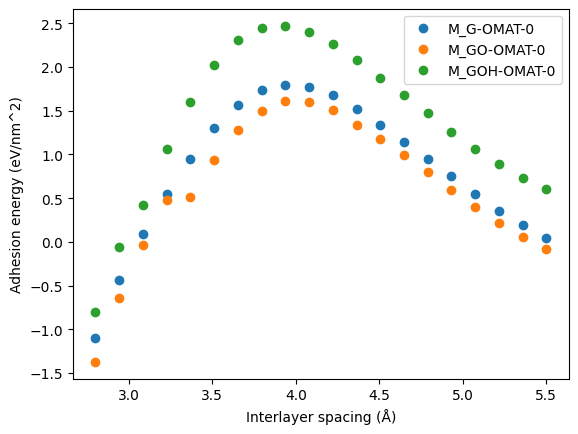

In [148]:
plt.plot(d, ad_energy_omat_flip, linestyle='', marker='o', label="M_G-OMAT-0", color = 'C0')
plt.plot(d, ad_energy_mgo_omat_flip, linestyle='', marker='o', label="M_GO-OMAT-0", color = 'C1')
plt.plot(d, ad_energy_mgoh_omat_flip, linestyle='', marker='o', label="M_GOH-OMAT-0", color = 'C2')

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm^2)")

Text(0, 0.5, 'Adhesion energy (eV/nm^2)')

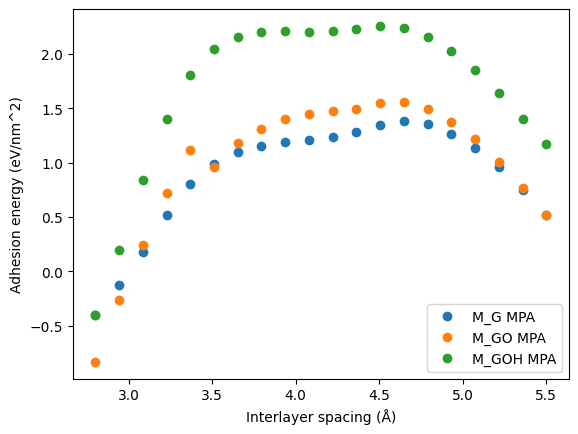

In [149]:
plt.plot(d, ad_energy_flip, linestyle='', marker='o', label="M_G MPA", color = 'C0')
plt.plot(d, ad_energy_mgo_flip, linestyle='', marker='o', label="M_GO MPA", color = 'C1')
plt.plot(d, ad_energy_mgoh_flip, linestyle='', marker='o', label="M_GOH MPA", color = 'C2')

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm^2)")

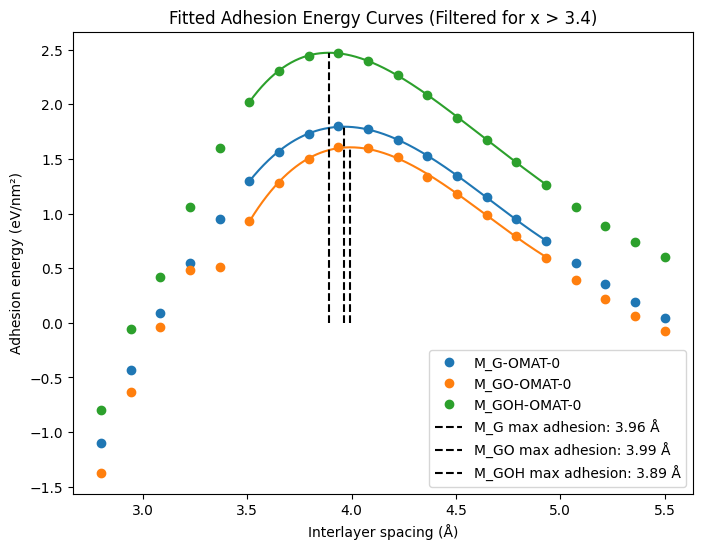

(3.9633266533066127,
 array(1.79465089),
 3.9946524628203774,
 array(1.60601177),
 3.8921316316844212,
 array(2.47127733))

In [ ]:
from scipy.interpolate import UnivariateSpline

filtered_indices = np.where((d > 3.4) & (d < 5))[:]


d_filtered = d[filtered_indices]
ad_energy_omat_filtered = np.array(ad_energy_omat_flip)[filtered_indices]
ad_energy_mgo_omat_filtered = np.array(ad_energy_mgo_omat_flip)[filtered_indices]
ad_energy_mgoh_omat_filtered = np.array(ad_energy_mgoh_omat_flip)[filtered_indices]

# smooth splines to the filtered dataset
spline_mg_filtered = UnivariateSpline(d_filtered, ad_energy_omat_filtered, s=0.1, k=4)
spline_mgo_filtered = UnivariateSpline(d_filtered, ad_energy_mgo_omat_filtered, s=0.1, k=4)
spline_mgoh_filtered = UnivariateSpline(d_filtered, ad_energy_mgoh_omat_filtered, s=0.1, k=4)


d_fine_filtered = np.linspace(d_filtered.min(), d_filtered.max(), 500)
max_d_mg_filtered = d_fine_filtered[np.argmax(spline_mg_filtered(d_fine_filtered))]
max_d_mgo_filtered = d_fine_filtered[np.argmax(spline_mgo_filtered(d_fine_filtered))]
max_d_mgoh_filtered = d_fine_filtered[np.argmax(spline_mgoh_filtered(d_fine_filtered))]

max_adhesion_mg_filtered = spline_mg_filtered(max_d_mg_filtered)
max_adhesion_mgo_filtered = spline_mgo_filtered(max_d_mgo_filtered)
max_adhesion_mgoh_filtered = spline_mgoh_filtered(max_d_mgoh_filtered)


plt.figure(figsize=(8, 6))
plt.plot(d, ad_energy_omat_flip, 'o', label="M_G-OMAT-0", color='C0')
plt.plot(d_fine_filtered, spline_mg_filtered(d_fine_filtered), '-', color='C0')

plt.plot(d, ad_energy_mgo_omat_flip, 'o', label="M_GO-OMAT-0", color='C1')
plt.plot(d_fine_filtered, spline_mgo_filtered(d_fine_filtered), '-', color='C1')

plt.plot(d, ad_energy_mgoh_omat_flip, 'o', label="M_GOH-OMAT-0", color='C2')
plt.plot(d_fine_filtered, spline_mgoh_filtered(d_fine_filtered), '-', color='C2')

plt.vlines(max_d_mg_filtered,0, max_adhesion_mg_filtered, linestyle='--', color='black', label=f"M_G max adhesion: {max_d_mg_filtered:.2f} Å")
plt.vlines(max_d_mgo_filtered, 0, max_adhesion_mgo_filtered, linestyle='--', color='black', label=f"M_GO max adhesion: {max_d_mgo_filtered:.2f} Å")
plt.vlines(max_d_mgoh_filtered, 0, max_adhesion_mgoh_filtered, linestyle='--', color='black', label=f"M_GOH max adhesion: {max_d_mgoh_filtered:.2f} Å")

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm²)")
plt.title("Fitted Adhesion Energy Curves (Filtered for x > 3.4)")
plt.show()


max_d_mg_filtered, max_adhesion_mg_filtered, max_d_mgo_filtered, max_adhesion_mgo_filtered, max_d_mgoh_filtered, max_adhesion_mgoh_filtered


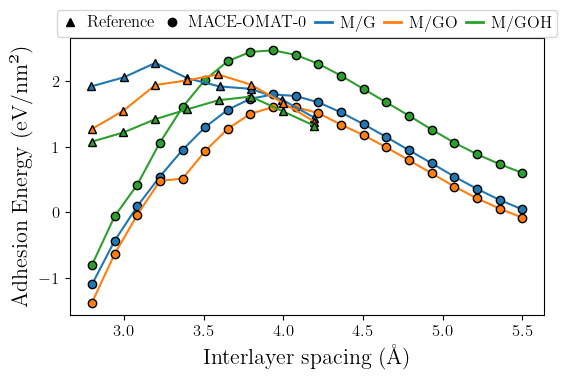

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(d, ad_energy_omat_flip, 'o-', label="M_G", markeredgecolor='black', color='C0')
plt.plot(d, ad_energy_mgo_omat_flip, 'o-', label="M_GO", markeredgecolor='black', color='C1')
plt.plot(d, ad_energy_mgoh_omat_flip, 'o-', label="M_GOH", markeredgecolor='black', color='C2')

plt.plot(values_x_mg, values_y_mg, label="M_G", marker="^", markeredgecolor='black', color='C0')
plt.plot(values_x_mgo, values_y_mgo, label="M_GO", marker="^", markeredgecolor='black', color='C1')
plt.plot(values_x_mgoh, values_y_mgoh, label="M_GOH", marker="^", markeredgecolor='black', color='C2')

legend_elements = [
    plt.Line2D([0], [0], linestyle="None", marker="^", color="black", label="Reference"),
    plt.Line2D([0], [0], linestyle="None", marker="o", color="black", label="MACE-OMAT-0"),
    plt.Line2D([0], [0], color="C0", lw=2, label="M/G"),
    plt.Line2D([0], [0], color="C1", lw=2, label="M/GO"),
    plt.Line2D([0], [0], color="C2", lw=2, label="M/GOH"),
]


#plt.legend(handles=legend_elements, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.13), frameon=True)
plt.legend(handles=legend_elements, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.13), frameon=True,
           columnspacing=0.5, handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=12, markerfirst=True)

plt.xlabel("Interlayer spacing (Å)", fontsize = 16)
plt.ylabel("Adhesion Energy (eV/nm²)", fontsize = 16)
plt.tight_layout()
#plt.savefig("figures/adhesion_energy.pdf")
plt.show()

### Reference data

In [160]:
import json

with open("ref_adhesion/adhesion_ref_MG.json", 'r') as f:
    adhesion_ref_MG = json.load(f)
with open("ref_adhesion/adhesion_ref_MGO.json", 'r') as f:
    adhesion_ref_MGO = json.load(f)
with open("ref_adhesion/adhesion_ref_MGOH.json", 'r') as f:
    adhesion_ref_MGOH = json.load(f)
    
values_x_mg = [i['value'][0] for i in adhesion_ref_MG['datasetColl'][0]['data']]
values_y_mg = [i['value'][1] for i in adhesion_ref_MG['datasetColl'][0]['data']]

values_x_mgo = [i['value'][0] for i in adhesion_ref_MGO['datasetColl'][0]['data']]
values_y_mgo = [i['value'][1] for i in adhesion_ref_MGO['datasetColl'][0]['data']]

values_x_mgoh = [i['value'][0] for i in adhesion_ref_MGOH['datasetColl'][0]['data']]
values_y_mgoh = [i['value'][1] for i in adhesion_ref_MGOH['datasetColl'][0]['data']]

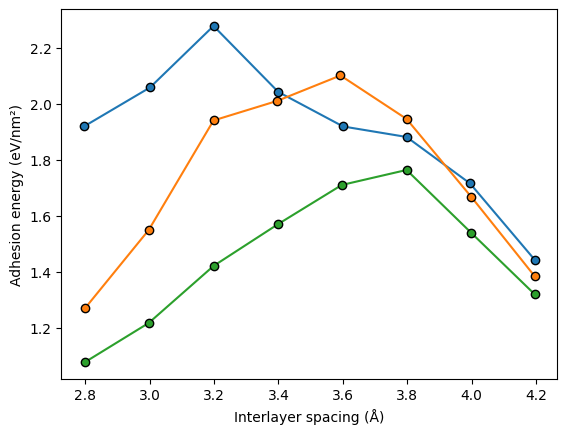

In [ ]:
plt.plot(values_x_mg, values_y_mg, label="M_G", marker="o", markeredgecolor='black', color='C0')
plt.plot(values_x_mgo, values_y_mgo, label="M_GO", marker="o", markeredgecolor='black', color='C1')
plt.plot(values_x_mgoh, values_y_mgoh, label="M_GOH", marker="o", markeredgecolor='black', color='C2')

plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion Energy (eV/nm²)")
plt.show()